# Import Library

In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
import requests,json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os
import re

from wordcloud import WordCloud, STOPWORDS
from langchain_community.llms import Replicate
from google.colab import userdata

# SET TOKEN AND MODEL

In [ ]:
#set the api token for granite ai
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

# SCRAPER DATA FROM TIKTOK

In [ ]:
# Input the link of the video you want to analyze
post_url = 'https://www.tiktok.com/@pandawaragroup/video/7520215015220055352' # can be changed to user input to make it interactive

In [ ]:
# get id from URL
post_id = post_url.split('/')[-1]

#set header
headers = {
  'accept': '*/*',
  'accept-language': 'en-US,en;q=0.9,fa;q=0.8',
  'cache-control': 'no-cache',
  'pragma': 'no-cache',
  'priority': 'u=1, i',
  'referer': 'https://www.tiktok.com/explore',
  'sec-ch-ua': '"Google Chrome";v="129", "Not=A?Brand";v="8", "Chromium";v="129"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'same-origin',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'
}

# variabel declaration
comments = []

comments.append({'post_url':post_url})

curs = 0

# func to request to tiktok API
def req(post_id,curs):

    url = f'https://www.tiktok.com/api/comment/list/?WebIdLastTime=1729273214&aid=1988&app_language=en&app_name=tiktok_web&aweme_id={post_id}&browser_language=en-US&browser_name=Mozilla&browser_online=true&browser_platform=Win32&browser_version=5.0%20%28Windows%20NT%2010.0%3B%20Win64%3B%20x64%29%20AppleWebKit%2F537.36%20%28KHTML%2C%20like%20Gecko%29%20Chrome%2F129.0.0.0%20Safari%2F537.36&channel=tiktok_web&cookie_enabled=true&count=20&cursor={curs}&data_collection_enabled=false&device_id=7427171842932786693&device_platform=web_pc&focus_state=true&from_page=video&history_len=6&is_fullscreen=false&is_page_visible=true&odinId=7427171704705188869&os=windows&priority_region=&referer=&region=CA&screen_height=1080&screen_width=1920&tz_name=Asia%2FTehran&user_is_login=false&webcast_language=en&msToken=U488DBL2ELMV88PxvXu7bOKQJVxuv7LnhKNHsWaOT2uQhpGyj5M-7EmUsXBIS9HbQ_bQ35u3Za-f_hVhHMMYsH-4mxWPeJoUeMhgOHOvQ-IaKb5lr3DlgBIYJXCUc9MCexCHXig1u4a98hVjnec74fs=&X-Bogus=DFSzswVYtfhANH-ltQ2xJbJ92U6T&_signature=_02B4Z6wo000017DRplgAAIDBt3uT.9qT9Zew0aLAAIsv87'

    response = requests.get(url=url, headers=headers)
    info = response.text
    raw_data = json.loads(info)
    print(curs)
    return raw_data

# func to parsing dat
def parser(data):
    comment = data['comments']

    for cm in comment:
        com = cm['share_info']['desc']

        if com == "":
            com = cm['text']
        #print(com)
        comments.append(com)

    return data

# load data
while 1:

    raw_data = req(post_id,curs)

    same_data = parser(raw_data)

    if same_data['has_more'] == 1:
        curs+=1
    else:
        print('no comments available')
        break


# get URL from first elemen
post_url = comments[0]['post_url']

# convert raw data to rows
rows = []
for i, entry in enumerate(comments[1:], start=1):
    if isinstance(entry, str) and ':' in entry:
        akun = entry.split(':')[0]
        komentar = entry.split(':') [-1]
        akun = akun.replace("'s comment", "").replace("’s comment", "")
        rows.append({
            'no': i,
            'post_url': post_url,
            'akun': akun.strip(),
            'comment': komentar.strip()
        })

# Safe to CSV
# this is the raw dataset that we will use
with open('comment_tiktok.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['no', 'post_url', 'akun', 'comment'])
    writer.writeheader()
    writer.writerows(rows)

print("\ndata has been saved...., good job gais")


# LOAD DATA TIKTOK COMMENTS

"TikTok Comments.csv" <br>
this is the raw dataset that we will use


In [ ]:
# load data from csv file
df= pd.read_csv('TikTok Comments.csv')
df = df.drop(columns=['no', 'post_url'])

df.head()

,akun,comment
0,Nadyaa,gw kira mayat manusia anj😭🙏
1,eidajer🐦,Allah 😭
2,Beautiespartner,"Udah dikafani, bukannya dikubur malah dibuang ..."
3,MIE AYAM 🐔,"sumpah,pandwara menurut gwa stop aja\nkalau di..."
4,yissa,"dikira pandawara babu kali ya,yang komen tolon..."


In [ ]:
# take only the comments column
df_comment = df.copy().drop(columns=['akun'])

df_comment.head()

,comment
0,gw kira mayat manusia anj😭🙏
1,Allah 😭
2,"Udah dikafani, bukannya dikubur malah dibuang ..."
3,"sumpah,pandwara menurut gwa stop aja\nkalau di..."
4,"dikira pandawara babu kali ya,yang komen tolon..."


In [ ]:
# get description from comments
df_comment.describe()

,comment
count,27483
unique,1387
top,😁
freq,623


# TRANSLATE COMMENTS TO ENGLISH


Granite model is better for analyzing with English language.

create a prompting function to translate each comment line into English, to facilitate and optimize the granite model for analysis

In [ ]:
# Create translation prompting function
def prompting_translation(comments):
  # Tuning hyperparameters for translation
  parameters = {
    'temperature' : 0.0,
    'top_p' : 1.0,
    'max_tokens' : 500
  }

  # Build prompt in English for better clarity
  prompt = f"""
  You're a professional translator. Translate 15 line in the following slang or non-slang comments into natural, fluent English to facilitate emotional sentimental analysis.
  Make sure to keep the meaning and tone intact. Avoid literal word-for-word translation.
  Keep the slang's casual vibe but make it understandable in English.

  notes:
  Make sure the output for 1 line is only 1 line, the maximum output you produce is 15 lines.

  format output:
  - <your translate result>
  - <your translate result>

  Special rules:
  - 😭 means “funny/laugh”. If more than one 😭, it means “very funny/full of laugh”.
  - 😭🙏 means “full of laugh, very funny”.

  Now translate the following comments:
  {comments}
  """

  # Invoke the model with the example prompt and hyperparameter
  response = output.invoke(prompt, parameters=parameters)

  # return response
  return response.strip()

## prompting using the batching metode

call the translator function to translate each comment line into English. Prompting will be done using a batching method to minimize the risk of AI errors.

In [ ]:
# variabel initiation
total_translation = len(df_comment)
translated_results = [] # for translated comments
batch_size = 15 # number of comment lines sent per batch prompting
looping = (total_translation // batch_size) +1 # total looping initiation for calling function

# prompting using the batching metode
# looping fo calling function
for i in range(looping):
  if df_comment.empty: # if dataframe is empty. then loop is finished
    break
  translate_comment = df_comment.head(batch_size)['comment'].tolist() # take the first 15 lines for convert to list datatype
  # change the form of the sentence, to suit the prompting
  translate_text = "\n".join(
        [f"comment {j+1}: {translate}" for j, translate in enumerate(translate_comment)]
      )

  # delete the first 15 lines
  df_comment = df_comment.iloc[batch_size:].reset_index(drop=True)

  # process to be displayed
  print(f"translating process: {i+1} / {looping}")

  # get response from granite model from prompting_translation function
  response = prompting_translation(translate_text)

  # safe result in translated_result variabel
  translated_results.extend([line for line in response.split('\n') if line.strip()])


if the output already displays "translating process: {looping}/{looping}" (ex: 138/138)

the prompting has been completed

## Data Cleaning

In [ ]:
# clean lines of comments
# delete "- " or "comment <number>: "
translated_results = [
    re.sub(r'^(-\s*|comment\s*\d+:\s*)', '', item, flags=re.IGNORECASE)
    for item in translated_results
]

## Data Backup

In [ ]:
# to secure data in case of eror
# save data english_comment to csv
df_english_comment = pd.DataFrame({'english_comment': translated_results})
df_english_comment.to_csv('english_comment.csv', index=False)

# CLASSIFY AND SUMMARIZE COMMENTS


classify and summarize comments for analysis sentiment and emotion from comments sentences

## prompting

In [ ]:
# Create classification and summarization prompting function
def prompting_classification(comment_text):
  # Tuning hyperparameters for classification and summarization
  parameters = {
          'temperature': 0.2,
          'top_p': 0.9,
          'max_tokens': 500,
          'presence_penalty': 0.0,
          'frequency_penalty': 0.0
  }

  # Build prompt in English for better clarity
  prompt = f"""
  Classify each line in the following review as Positive, Negative, or Mixed, and provide a brief summary or explanation (maximum 2 sentences).
  Also include one of the six basic emotions based on Ekman's model: Happiness, Sadness, Fear, Anger, Surprise, and Disgust.

  notes:
  Make sure the output for 1 line is only 1 line, the maximum output you produce is 15 lines.

  Output format:
  Review 1: Positive - Happiness - The movie was an absolute delight, filled with heartwarming moments and brilliant performances.
  Review 2: Negative - Disgust - The plot twists were predictable and the ending was a total letdown, leaving a sour taste.
  Review 3: Mixed - Surprise - I was pleasantly surprised by the unexpected turn of events, but the pacing was a bit slow.
  Review 4: Positive - Happiness - The special effects were stunning, adding a layer of excitement and wonder to the film.

  Special rules:
  - 😭 means “funny/laugh”. If more than one 😭, it means “very funny/full of laugh”.
  - 😭🙏 means “full of laugh, very funny”.
  - Write the results per comment, without additional paragraphs.
  - Use only one of the main categories: Positive, Negative, Mixed, or Neutral.
  - Use one of Ekman's 6 basic emotion categories.

  Now classify the following reviews:

  {comment_text}
  """

  # Invoke the model with the example prompt and hyperparameter
  response = output.invoke(prompt, parameters=parameters)

  # return response
  return response.strip()


## prompting using the batching metode

call the classification function to summarize and classify each comment line . Prompting will be done using a batching method to minimize the risk of AI errors.

In [ ]:
# variabel initiation
total_classification = int(len(translated_results))

classification_result = [] # for classification result
batch_size = 15 # number of comment lines sent per batch prompting
looping = (total_classification // batch_size) +1 # total looping initiation for calling function

# prompting using the batching metode
# looping fo calling function
for i in range(looping):
  if not translated_results: # if translated_results is empty. then loop is finished
    break
  reviews_comment = translated_results[:batch_size] # take the first 15 lines for convert to list datatype
  # change the form of the sentence, to suit the prompting
  comment_text = "\n".join(
        [f"Review {j+1}: {review}" for j, review in enumerate(reviews_comment)]
      )

  # delete the first 15 lines
  translated_results = translated_results[batch_size:]

  # process to be displayed
  print(f"classfification process: {i+1} / {looping}")

  # get response from granite model from prompting_translation function
  response = prompting_classification(comment_text)

  # safe result in translated_result variabel
  classification_result.extend([line for line in response.split('\n') if line.strip()])

if the output already displays "translating process: {looping}/{looping}" (ex: 138/138)

the prompting has been completed

## Data Cleaning

In [ ]:
# clean lines of results
# Extract the text after the colon (if present).
# Remove the numbers + periods + spaces at the beginning of the text.
classification_result = [
    re.sub(r'^\d+\.\s*', '', item.split(':', 1)[1].strip() if ':' in item else item)
    for item in classification_result
]

In [ ]:
# delete lines that do not have the "-"" character
classification_result = list(filter(lambda x: '-' in x, classification_result))


0


In [ ]:
# delete rows that do not have 3 return values
classification_result = [
    item for item in classification_result
    if len(item.split(' - ', 2)) == 3
]


In [ ]:
# separate rows into 3 categories: "sentimen", "emotion", "summaries"
sentiment = []
emotion = []
summaries = []
for item in classification_result:
  sent, emo, summary = item.split(' - ', 2)
  sentiment.append(sent)
  emotion.append(emo)
  summaries.append(summary)

## Data Backup

In [ ]:
# create a data frame with 3 columns: "sentimen", "emotion", "summaries"
df_sentiment = pd.DataFrame({
    'sentiment': sentiment,
    'emotion': emotion,
    'summary': summaries
})

df_sentiment = df_sentiment.sort_values(by='sentiment', ascending=False)
df_sentiment.head()

,sentiment,emotion,summary
0,🥺🙏🏻🙏🏻,Mixed,Surprise - The reviewer is surprised and grate...
3,🥺,Sadness,The reviewer is saddened by the situation and ...
1,🥺,Sadness,The reviewer is expressing sadness and disappo...
2,🥺,Sadness,"The reviewer expresses fear, indicating a nega..."
4,🥰🥰🥰,Happiness,The reviewer finds the situation cute or endea...


In [ ]:
# save the sentiment analysis results into a csv file
df_sentiment.to_csv('sentiment_result.csv', index=False)

# INSIGHT CAPTURE

## Data Loading

In [74]:
# load data from csv
df_sentiment = pd.read_csv('Sentiment Results.csv')

df_sentiment.head()

,sentiment,emotion,summary
0,🥺🙏🏻🙏🏻,Mixed,Surprise - The reviewer is surprised and grate...
1,🥺,Sadness,The reviewer is expressing sadness and disappo...
2,🥺,Sadness,"The reviewer expresses fear, indicating a nega..."
3,🥺,Sadness,The reviewer is saddened by the situation and ...
4,🥰🥰🥰,Happiness,The reviewer finds the situation cute or endea...


In [75]:
# get data description
df_sentiment.describe()

,sentiment,emotion,summary
count,21361,20945,21360
unique,167,468,19635
top,Positive,Happiness,😁
freq,7799,6565,46


In [76]:
# get basic data information
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21361 entries, 0 to 21360
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  21361 non-null  object
 1   emotion    20945 non-null  object
 2   summary    21360 non-null  object
dtypes: object(3)
memory usage: 500.8+ KB


## Data cleaning

### sentiment cleaning

In [78]:
# Valid sentiments category list
valid_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']

# delete rows that have other than valid sentiments category
df_sentiment = df_sentiment[df_sentiment['sentiment'].isin(valid_sentiments)].reset_index(drop=True)


### emotion cleaning

In [83]:
df_emotions = df_sentiment.groupby('emotion', as_index=False).size()
df_emotions.columns = ['emotion', 'count']  # chance nome of columns for clarity

# take the emotion if the number of emotion more than 11
df_emotions = df_emotions[df_emotions['count'] >= 11]


In [88]:
# change valid emotion to list
valid_emotions = df_emotions['emotion'].tolist()

# deletes rows if does'nt have a valid emotion
df_sentiment = df_sentiment[df_sentiment['emotion'].isin(valid_emotions)]



In [89]:
df_sentiment.describe()

,sentiment,emotion,summary
count,14763,14763,14763
unique,4,6,13864
top,Positive,Happiness,😁
freq,6629,6478,42


# CHART AND WORD CLOUD

## create a wordcloud

In [ ]:
# Gabungkan semua teks di kolom 'summary' menjadi satu string
text = " ".join(df_sentiment['summary'].astype(str))

stopwords = set(STOPWORDS)
stopwords.update(["yang", "dan", "di", "ke", "untuk"])  # kata tambahan

# Buat word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis'
).generate(text)


## show diagram and wordcload

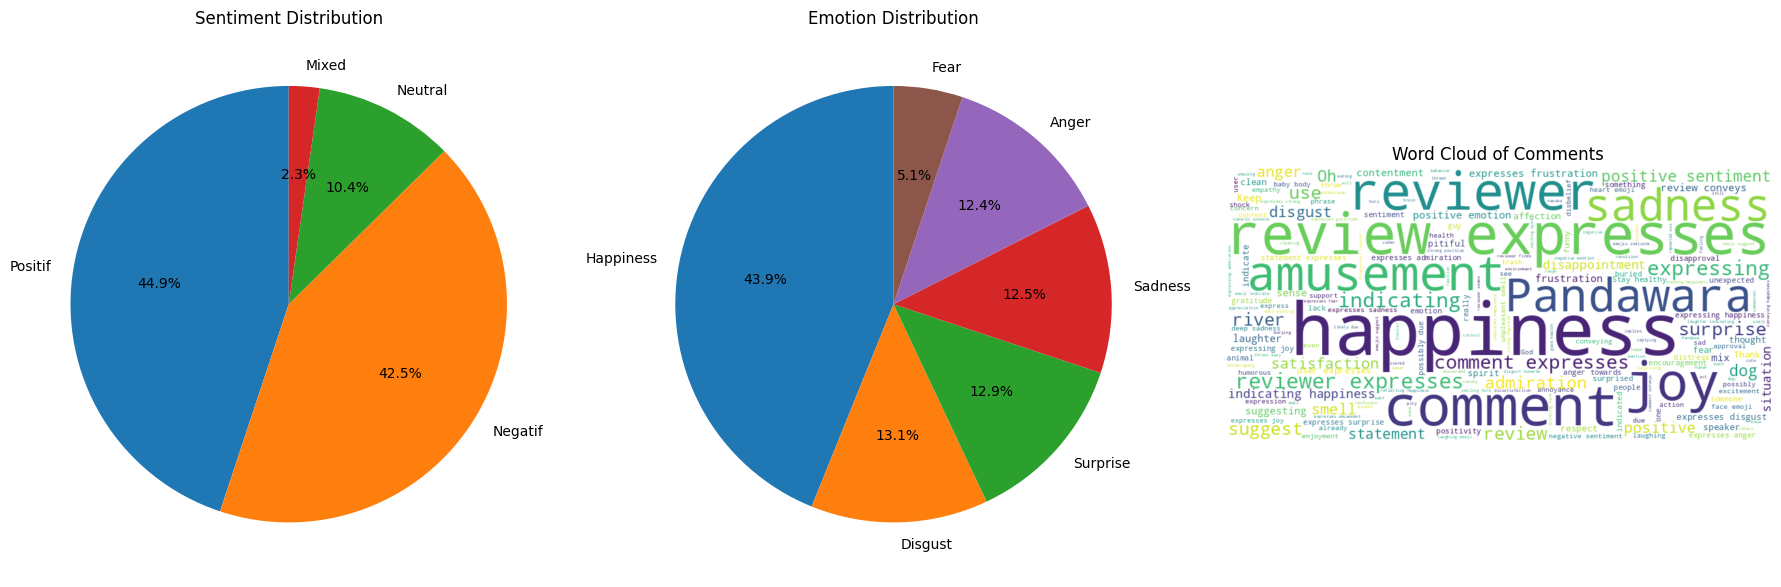

In [98]:
# Buat figure
plt.figure(figsize=(18, 6))

# Pie chart: Sentiment
plt.subplot(1, 3, 1)
plt.pie(
    df_sentiment['sentiment'].value_counts(),
    labels=['Positif', 'Negatif', 'Neutral', 'Mixed'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Sentiment Distribution')

# Pie chart: Emotion
plt.subplot(1, 3, 2)
counts = df_sentiment['emotion'].value_counts().index  # pastikan ini sesuai
plt.pie(
    df_sentiment['emotion'].value_counts(),
    labels=counts,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Emotion Distribution')

# Word Cloud
plt.subplot(1, 3, 3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')

plt.tight_layout()
plt.show()


# ANALYSIS RESULT

1. Analisis Sentiment Distribution
- Positif (44.9%) → Hampir setengah komentar bernada positif. Mayoritas berisi dukungan, apresiasi, dan rasa bangga kepada Pandawara yang tetap melakukan aksi bersih-bersih sungai meskipun ada gangguan.

- Negatif (42.5%) → Angka ini cukup tinggi, tetapi besar kemungkinan diarahkan kepada pelaku prank atau situasi prank itu sendiri, bukan kepada Pandawara. Komentar negatif ini cenderung berupa kemarahan, kekecewaan, atau kritik terhadap aksi prank yang dianggap tidak pantas.

- Netral (10.4%) → Berisi komentar yang cenderung informatif atau hanya menyatakan fakta tanpa emosi yang jelas.

- Mixed (2.3%) → Komentar yang mengandung sentimen campuran, misalnya memuji Pandawara tetapi tetap mengungkapkan rasa kesal terhadap prank tersebut.

💡 Insight: Walaupun ada tingkat negatif yang besar, konteks menunjukkan bahwa negatif ini lebih sebagai bentuk pembelaan terhadap Pandawara—audiens marah pada prank, bukan kreator.
<br><br>
2. Analisis Emotion Distribution
- Happiness (43.9%) → Emosi dominan, kemungkinan berasal dari rasa lega ketika tahu benda mencurigakan itu bukan korban sungguhan, serta rasa kagum terhadap dedikasi Pandawara.

- Disgust (13.1%) & Surprise (12.9%) → Menandakan kejutan awal saat melihat “mayat” dan rasa jijik atau kecewa terhadap prank tersebut.

- Sadness (12.5%) & Anger (12.4%) → Menunjukkan simpati kepada Pandawara sekaligus kemarahan terhadap pelaku prank.

- Fear (5.1%) → Rasa takut awal sebelum kebenaran terungkap.

💡 Insight: Gabungan disgust, sadness, anger, dan fear membentuk reaksi emosional negatif yang diarahkan ke pelaku prank, sementara happiness menjadi sinyal bahwa reputasi Pandawara tidak terganggu secara signifikan.
<br><br>
3. Analisis Word Cloud
- Kata “Pandawara” menjadi pusat perhatian, menegaskan bahwa identitas kreator sangat kuat di benak audiens.

- Kata-kata seperti happiness, joy, admiration menunjukkan dukungan dan rasa hormat.

- Kata disgust, anger, sadness menandakan reaksi emosional terhadap prank yang dilakukan pihak lain.

- Kata “expresses” atau “reviewer” adalah artefak dari proses terjemahan dan labeling, sehingga sebaiknya difilter di analisis lanjutan agar tidak mengganggu interpretasi.
<br><br>
4. Kesimpulan untuk Kreator
- Kekuatan: Tingginya positif dan happiness menunjukkan Pandawara mendapatkan empati publik. Dukungan audiens kuat meskipun ada insiden kontroversial.

- Risiko: Besarnya porsi emosi negatif menunjukkan publik terprovokasi oleh prank tersebut. Jika tidak segera diluruskan, bisa menimbulkan salah paham.
<br><br>
Saran:

- Klarifikasi cepat di awal atau di caption bahwa Pandawara adalah korban prank.

- Manfaatkan momentum empati untuk memperkuat brand sebagai pejuang lingkungan yang tahan ujian.

- Buat konten edukasi tentang bahaya prank di area publik untuk mengubah kemarahan audiens menjadi dukungan.

